In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import utils.functions as f

# Direct Matching Dataset

In [ ]:
direct_matching_df = pd.read_csv('Data/direct_matching_20240213.csv', sep=';')

In [ ]:
direct_matching_df.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
0,"5,664,912",OFF_1011_1427,32.327042,99.573387,1,Male,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
1,"4,999,120",OFF_1011_1427,15.595593,99.210564,2,Male,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
2,"5,413,671",OFF_1011_1427,31.348877,99.118614,3,Female,45-54,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
3,"5,965,090",OFF_1011_1427,66.315598,97.409767,4,Male,15-24,TS,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD
4,"5,771,219",OFF_1011_1427,15.595593,97.323875,5,Female,35-44,UD,FRIULI VENEZIA GIULIA,NaN,NaN,Lavoro subordinato,Geometra e tecnico di costruzioni civili e ind...,Progettisti / Design / Grafici,UD


In [ ]:
direct_matching_df.describe(include="all")

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
count,8647,8647,8647.000000,8647.000000,8647.000000,8647,8646,8644,8642,2341,2355,8647,8647,8647,8647
unique,6798,865,NaN,NaN,NaN,2,5,79,18,433,96,3,247,26,53
top,"6,550,205",OFF_1011_1427,NaN,NaN,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Rumeno,Lavoro subordinato,Operaio Generico Metalmeccanico,Operai Generici,MI
freq,18,10,NaN,NaN,NaN,4766,2936,1341,3989,433,821,5658,770,2829,1689
mean,NaN,NaN,29.769432,99.633988,5.499480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,23.493063,1.071380,2.872447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,69.610825,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,12.253924,99.676991,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,23.447361,99.856033,5.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,41.754654,99.932602,8.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
direct_matching_df['cand_languages_spoken'] = direct_matching_df['cand_languages_spoken'].fillna('Italiano')
direct_matching_df['cand_education'] = direct_matching_df['cand_education'].fillna('no education')

In [ ]:
education_mapping = {
    'no education' : 0,
    'licenza elementare': 1,
    'elementari': 2,
    'licenza media': 3,
    'diploma / accademia': 4,
    'qualifica / attestato': 5,
    'istituto tecnico superiore (its)': 6,
    'laurea triennale': 7,
    'master universitario': 8,
    'laurea magistrale': 9,
    'dottorato di ricerca': 10,
}

reverse_education_mapping = {value: key for key, value in education_mapping.items()}

education_counter_total = {}
education_counter_max = {}
for edu in education_mapping.keys():
  education_counter_max[edu] = 0
  education_counter_total[edu] = 0

In [ ]:
df_without_nulls = direct_matching_df.dropna()

education_lvl = df_without_nulls.cand_education
row_to_education = {}
set_education = set()

### Dictionary containing row in which the candidate appear-education ###
for idx,edu in education_lvl.items():
  if ";" in edu:
    qualifications = edu.split(";")
  else:
    qualifications = [edu]
  title = []
  for level in qualifications:
    if ":" in level:

      new_value = level.split(":")[0].strip().lower()
    else:
      new_value = level.strip().lower()
    title.append(new_value)
    set_education.add(new_value)

    #For counting
    education_counter_total[new_value] += 1

  row_to_education[idx] = title


### The loop below is used to retain only the highest education in the CV according to the dictionary above (may be wrong) ###
for row, education in row_to_education.items():
  mapped_value = []
  if len(education) > 1:
    for title in education:
      mapped_value.append(education_mapping[title])
    max_lvl_education = max(mapped_value)
    new_education = reverse_education_mapping[max_lvl_education]

    education_counter_max[new_education] += 1
    row_to_education[row] = [new_education]
  else:
    education_counter_max[education[0]] += 1

education_counter_total['licenza elementare'] += education_counter_total['elementari']
del education_counter_total['elementari']  # same name for the 2 values

education_counter_max['licenza elementare'] += education_counter_max['elementari']
del education_counter_max['elementari']

In [ ]:
education_counter_total,sum(education_counter_max.values())

({'no education': 6298,
  'licenza elementare': 22,
  'licenza media': 504,
  'diploma / accademia': 1138,
  'qualifica / attestato': 507,
  'istituto tecnico superiore (its)': 169,
  'laurea triennale': 182,
  'master universitario': 33,
  'laurea magistrale': 200,
  'dottorato di ricerca': 5},
 8639)

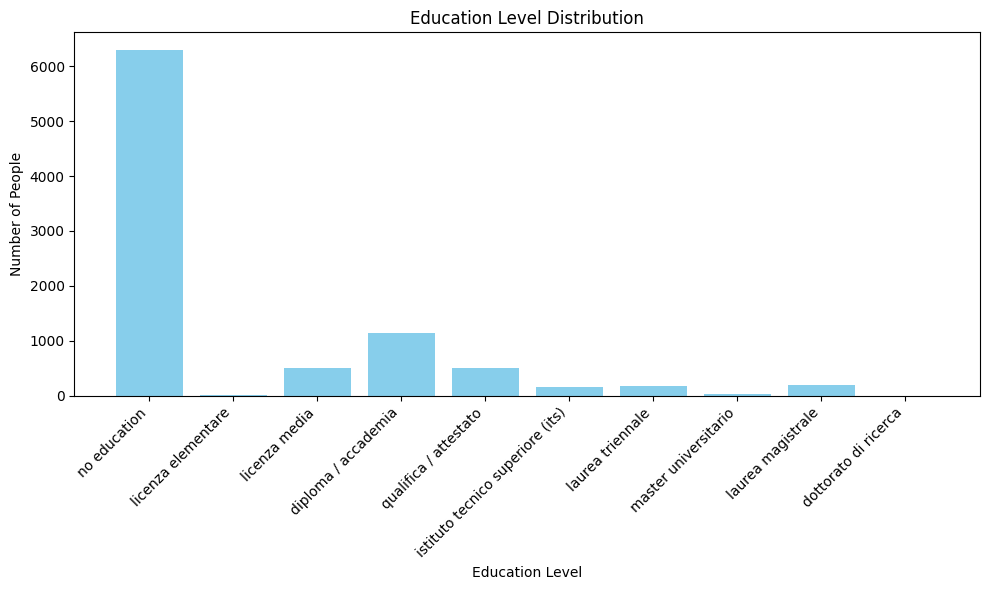

In [ ]:
education_levels = list(education_counter_total.keys())
count_values = list(education_counter_total.values())

plt.figure(figsize=(10, 6))
plt.bar(education_levels, count_values, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.title('Education Level Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Languages

In [ ]:
languages_spoken = df_without_nulls.cand_languages_spoken
counter_languages = {}
set_languages = set()

for idx,langs in languages_spoken.items():
  if ";" in langs:
    languages = langs.split(";")
  else:
    languages = [langs]

  for lang in languages:
      new_lang = lang.strip().lower()
      set_languages.add(new_lang)
      if new_lang in counter_languages:
        counter_languages[new_lang] += 1
      else:
        counter_languages[new_lang] = 1

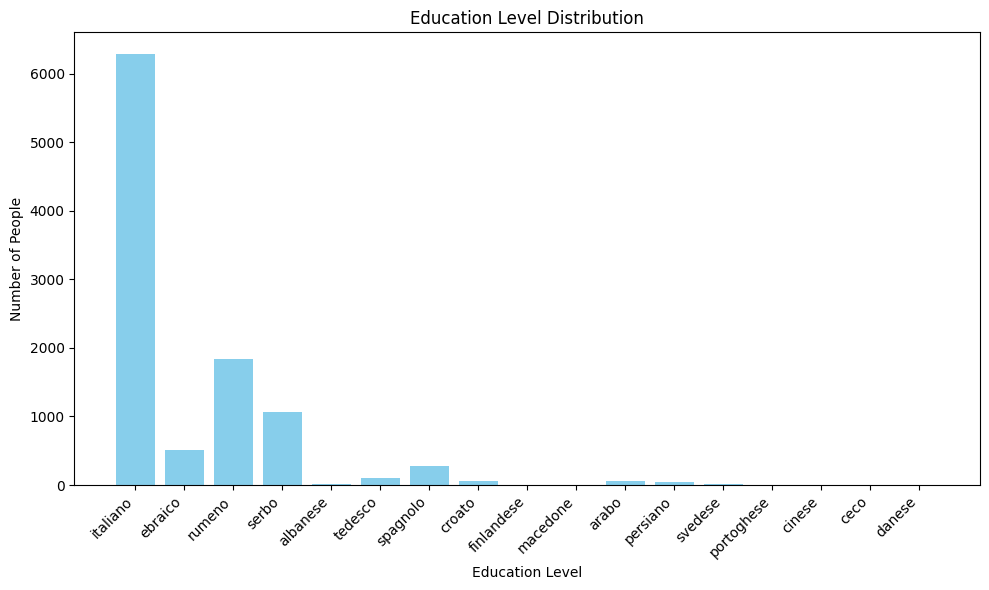

In [ ]:
languages_levels = list(counter_languages.keys())
count_languages = list(counter_languages.values())

plt.figure(figsize=(10, 6))
plt.bar(languages_levels, count_languages, color='skyblue')
plt.xlabel('Education Level')
plt.ylabel('Number of People')
plt.title('Education Level Distribution')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Analysis on top x candidates

In [ ]:
for idx, edu in row_to_education.items():
  direct_matching_df.cand_education.loc[idx] = edu[0]

In [ ]:
top_1_cands = f.get_rank_n_candidates(direct_matching_df,1)
top_2_cands = f.get_rank_n_candidates(direct_matching_df,2)
top_3_cands = f.get_rank_n_candidates(direct_matching_df,3)
top_4_cands = f.get_rank_n_candidates(direct_matching_df,4)
top_5_cands = f.get_rank_n_candidates(direct_matching_df,5)
top_6_cands = f.get_rank_n_candidates(direct_matching_df,6)
top_7_cands = f.get_rank_n_candidates(direct_matching_df,7)
top_8_cands = f.get_rank_n_candidates(direct_matching_df,8)
top_9_cands = f.get_rank_n_candidates(direct_matching_df,9)
top_10_cands = f.get_rank_n_candidates(direct_matching_df,10)

## Discretization of distances

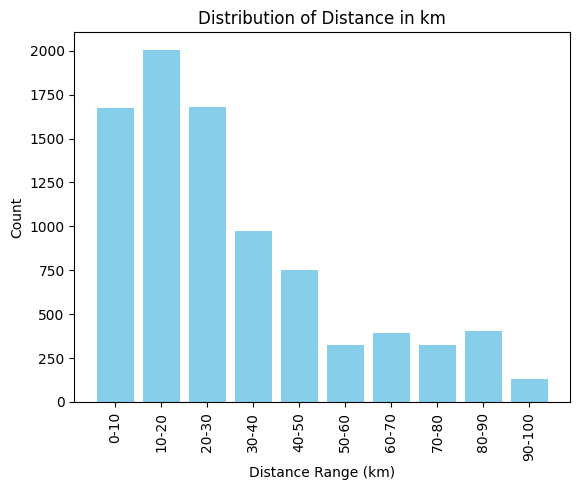

In [ ]:
distances_km = direct_matching_df.distance_km
distances_km = f.discretize_feature(distances_km)

total_distances = np.sum(distances_km)
dict_distances = {}
for i in range(10):
  dict_distances[i] = np.around(distances_km[i]/total_distances,4)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

# Plot the distribution with labels
plt.bar(labels, distances_km, color='skyblue')
plt.title('Distribution of Distance in km')
plt.xlabel('Distance Range (km)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [ ]:
dict_gender = f.create_dictionary_from_series(direct_matching_df.cand_gender.value_counts())
dict_age = f.create_dictionary_from_series(direct_matching_df.cand_age_bucket.value_counts())
dict_domicile_region = f.create_dictionary_from_series(direct_matching_df.cand_domicile_region.value_counts())
dict_job_province = f.create_dictionary_from_series(direct_matching_df.job_work_province.value_counts())
dict_education = f.create_dictionary_from_series(direct_matching_df.cand_education.value_counts())

In [ ]:
columns = ['cand_gender','cand_age_bucket','cand_domicile_region','job_work_province','cand_education']
top_1_dicts = f.create_dicts_rank_n(top_1_cands,columns)
top_2_dicts = f.create_dicts_rank_n(top_2_cands,columns)
top_3_dicts = f.create_dicts_rank_n(top_3_cands,columns)
top_4_dicts = f.create_dicts_rank_n(top_4_cands,columns)
top_5_dicts = f.create_dicts_rank_n(top_5_cands,columns)
top_6_dicts = f.create_dicts_rank_n(top_6_cands,columns)
top_7_dicts = f.create_dicts_rank_n(top_7_cands,columns)
top_8_dicts = f.create_dicts_rank_n(top_8_cands,columns)
top_9_dicts = f.create_dicts_rank_n(top_9_cands,columns)
top_10_dicts = f.create_dicts_rank_n(top_10_cands,columns)

full_dicts = [dict_distances,dict_gender,dict_age,dict_domicile_region,dict_job_province,dict_education]

list_of_dict = [full_dicts,top_1_dicts,top_2_dicts,top_3_dicts,top_4_dicts,top_5_dicts,top_6_dicts,top_7_dicts,top_8_dicts,top_9_dicts,top_10_dicts]

In [ ]:
direct_distance_km = f.create_table_for_feature(list_of_dict,idx=0)
direct_gender = f.create_table_for_feature(list_of_dict,idx=1)
direct_age = f.create_table_for_feature(list_of_dict,idx=2)
direct_home_region = f.create_table_for_feature(list_of_dict,idx=3)
direct_job_province = f.create_table_for_feature(list_of_dict,idx=4)
direct_education = f.create_table_for_feature(list_of_dict,idx=5)

## Print single Feature

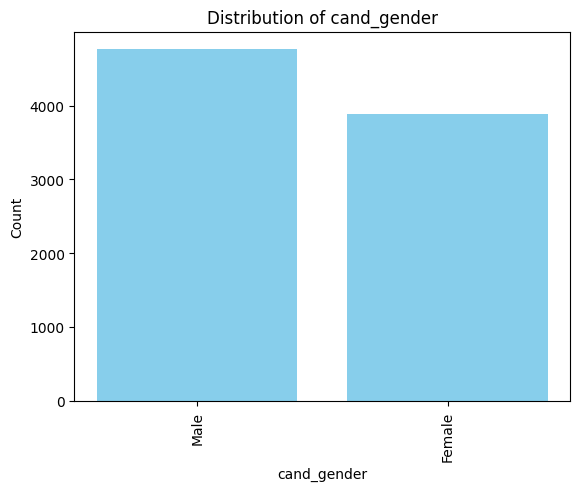

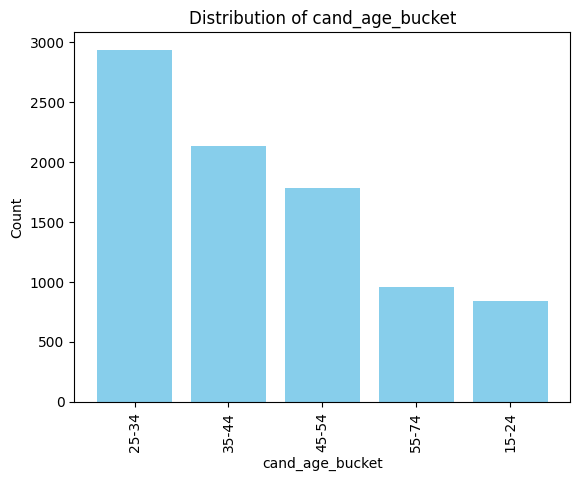

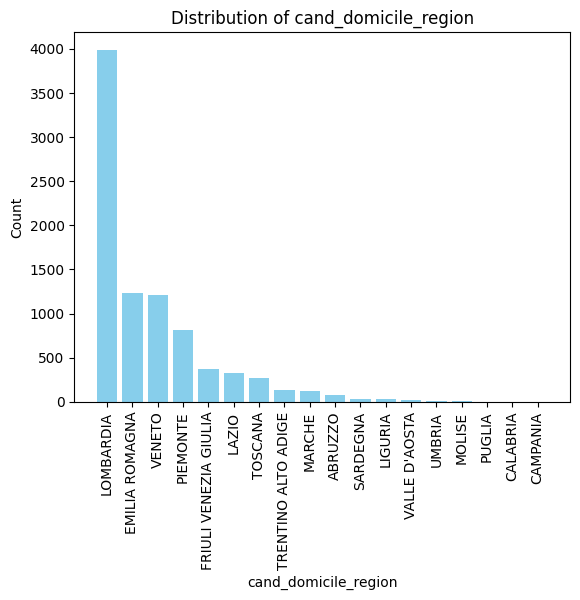

In [ ]:
f.show_global_distribution(df_without_nulls,'cand_gender')
f.show_global_distribution(df_without_nulls,'cand_age_bucket')
f.show_global_distribution(df_without_nulls,'cand_domicile_region')

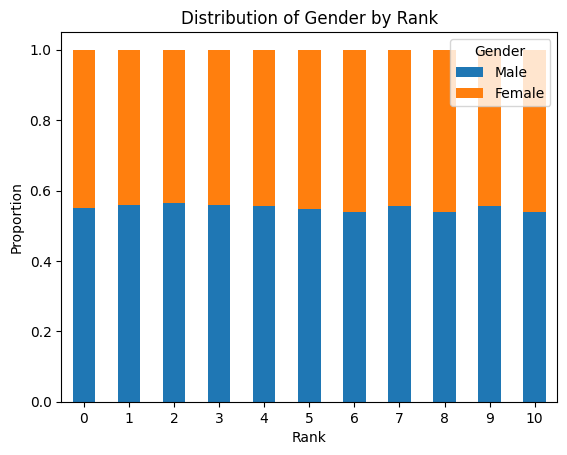

In [ ]:
f.print_feature_distribution(direct_gender,'Gender')

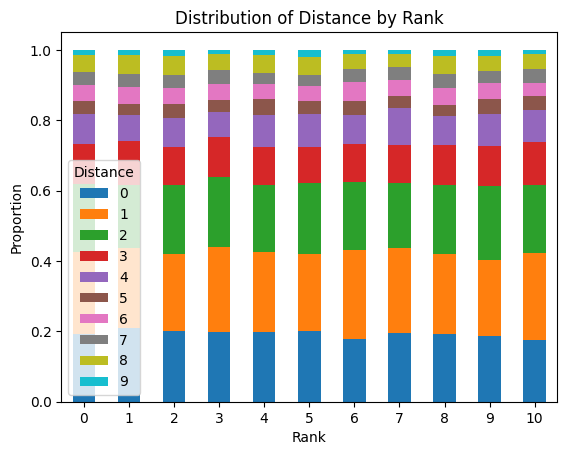

In [ ]:
f.print_feature_distribution(direct_distance_km,'Distance')

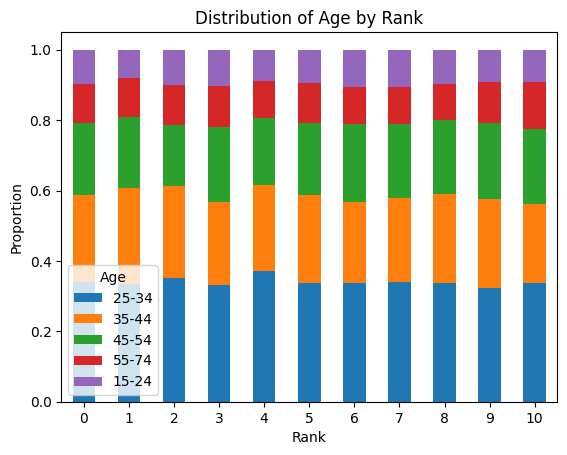

In [ ]:
f.print_feature_distribution(direct_age,'Age')

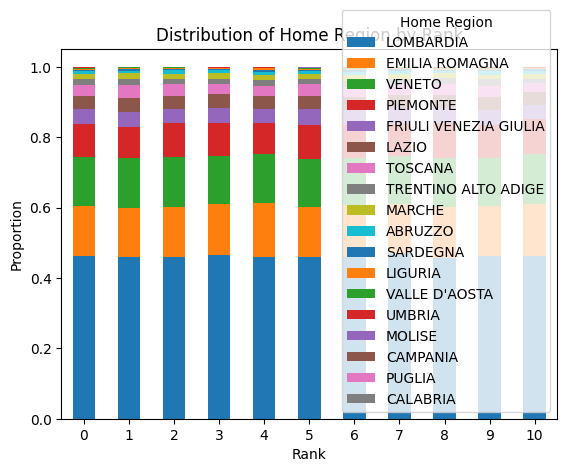

In [ ]:
f.print_feature_distribution(direct_home_region,'Home Region')

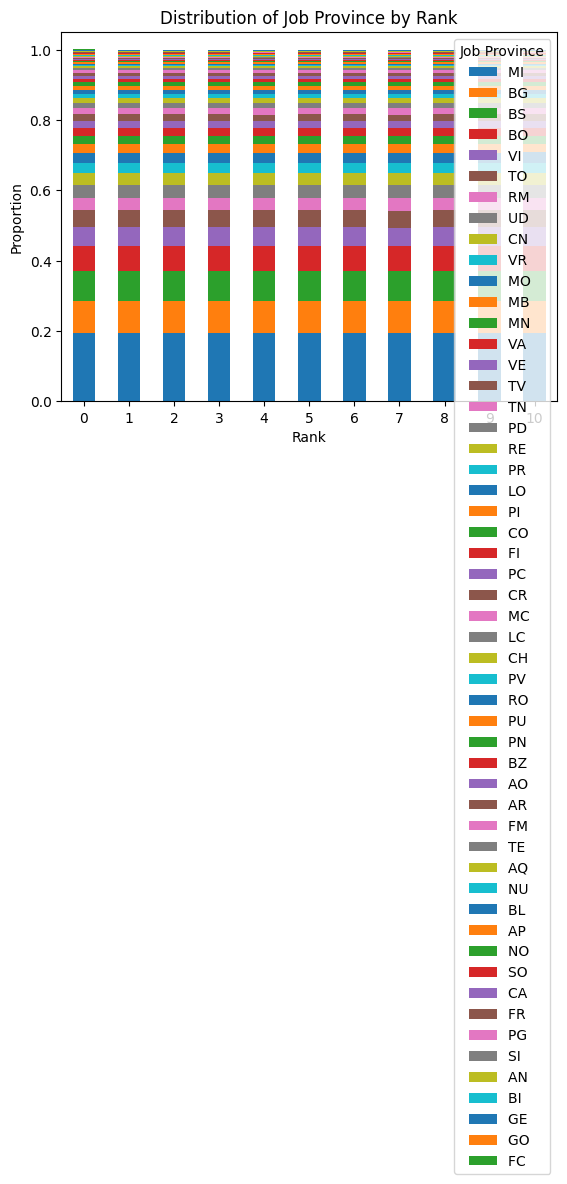

In [ ]:
f.print_feature_distribution(direct_job_province,'Job Province')

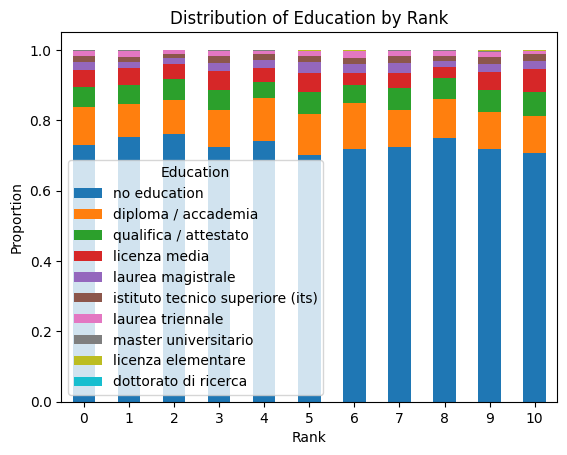

In [ ]:
f.print_feature_distribution(direct_education,'Education')

## Test 2 features together

In [ ]:
direct_matching_df = direct_matching_df.dropna()
direct_matching_df['distance_km'] = (direct_matching_df['distance_km'] // 10)

<ipython-input-72-da7d8440770e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  direct_matching_df['distance_km'] = (direct_matching_df['distance_km'] // 10)


### Gender & Education

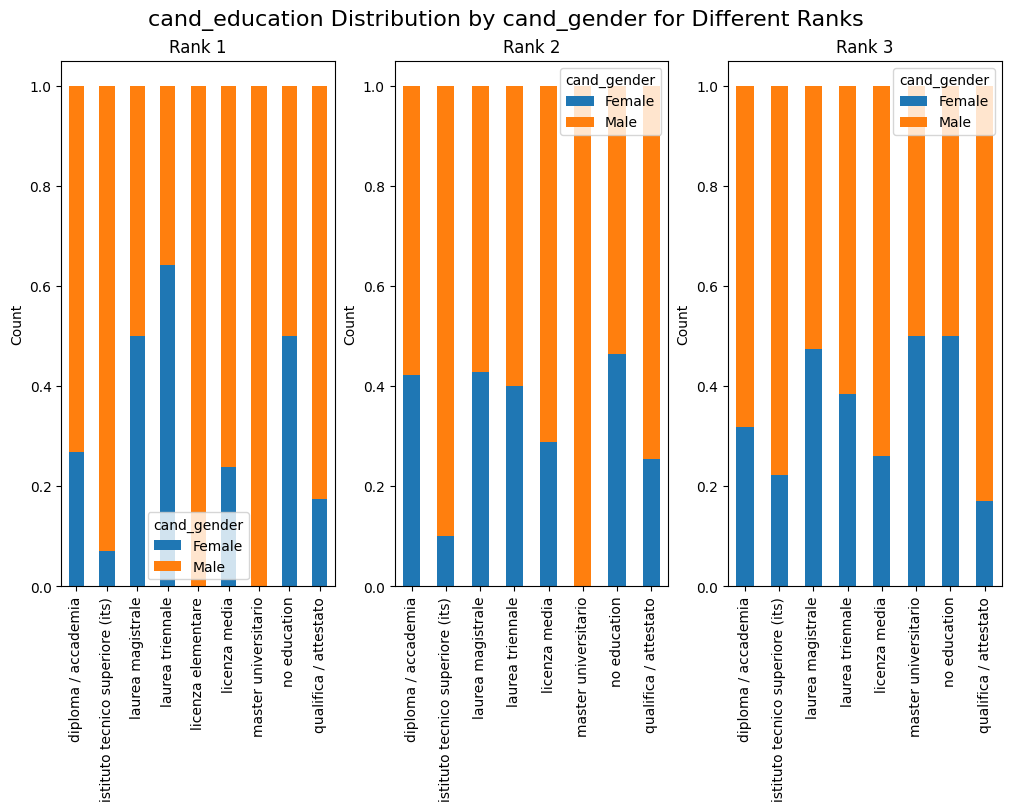

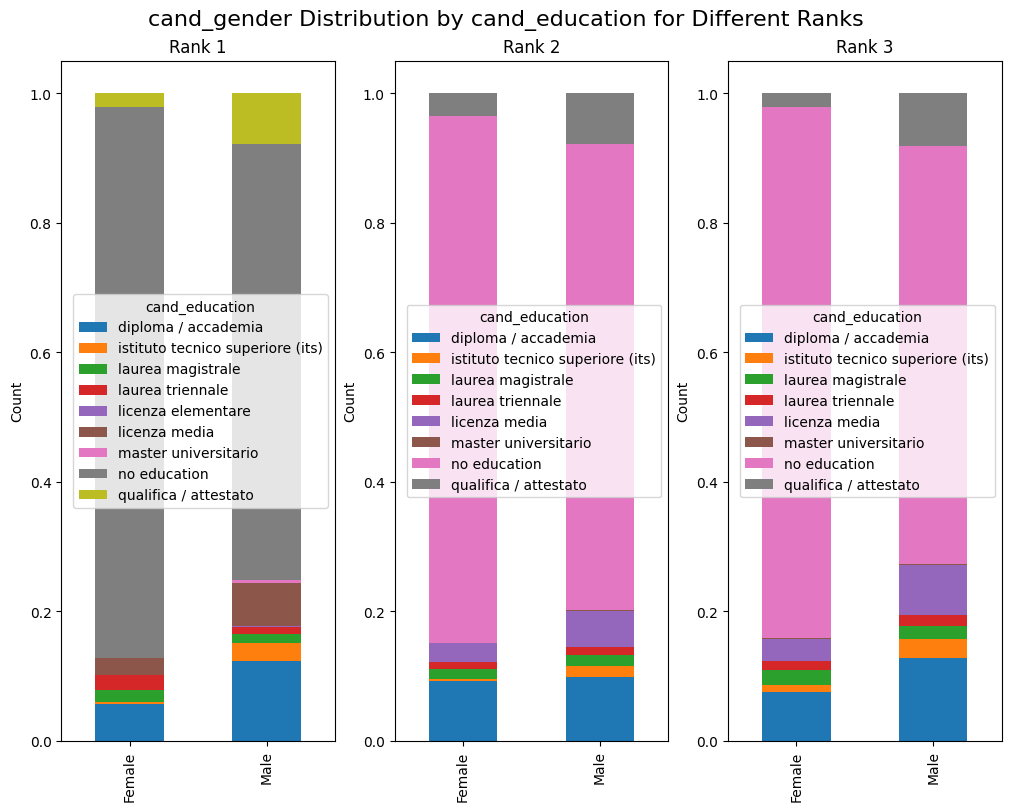

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df,'cand_education','cand_gender',r,len(r))
f.plot_2_features(direct_matching_df,'cand_gender','cand_education',r,len(r))

### Gender & distance

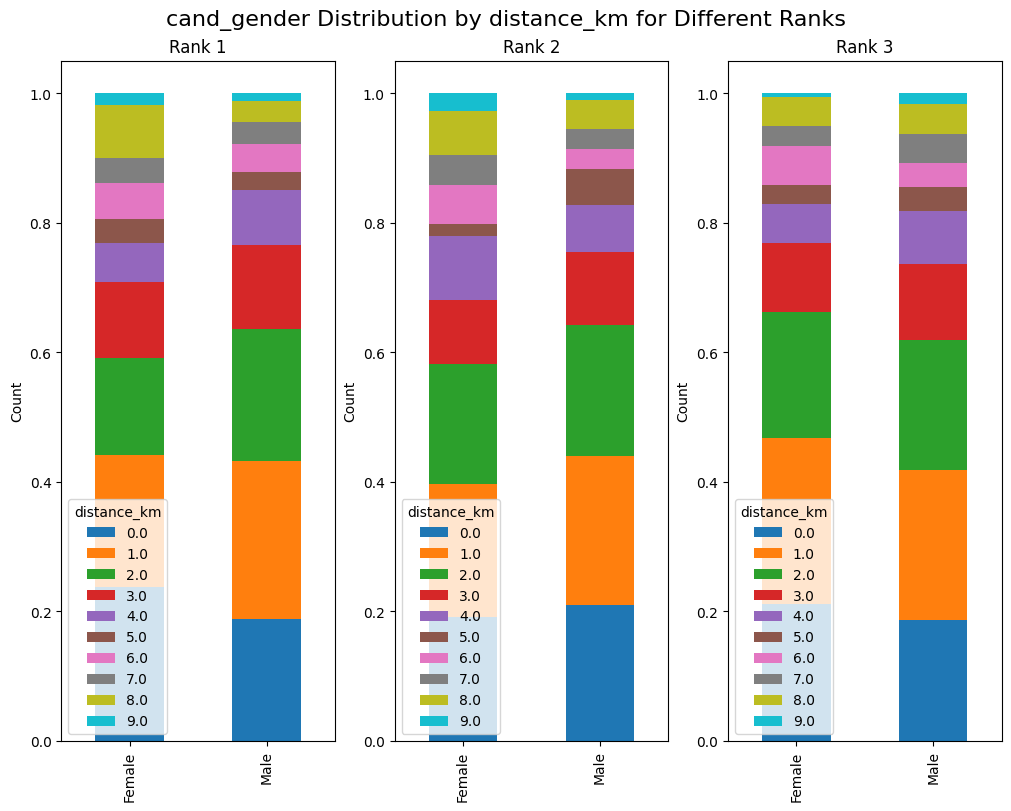

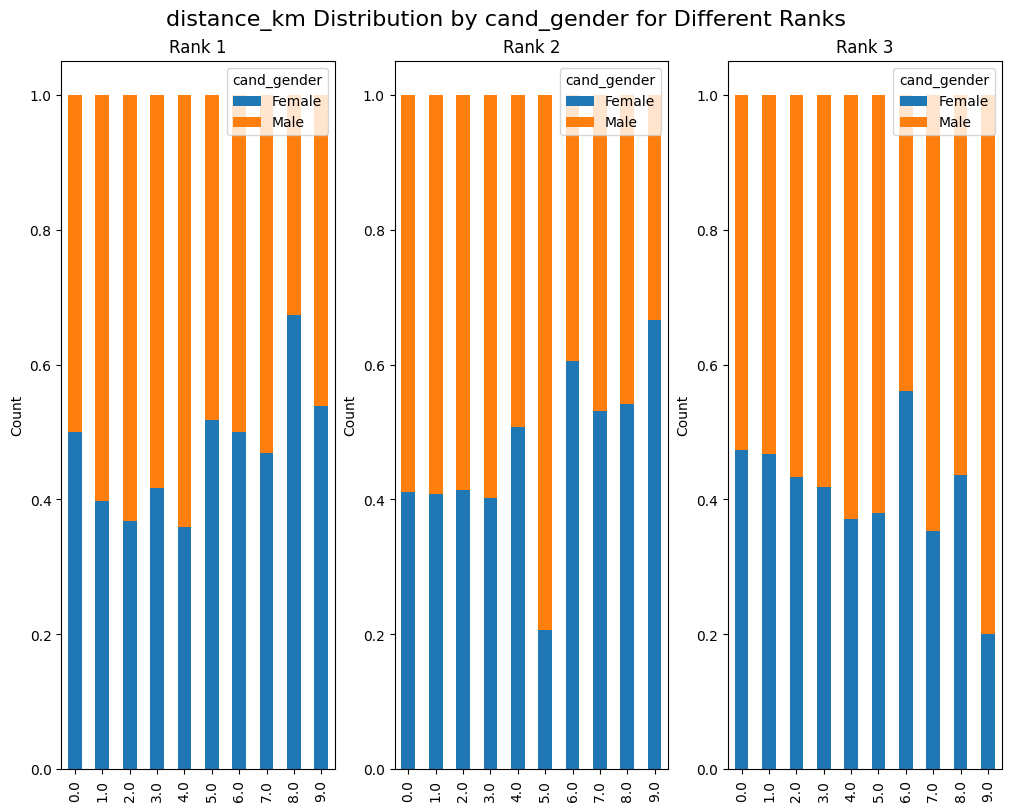

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df.dropna(),'cand_gender','distance_km',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'distance_km','cand_gender',r,len(r))

### Gender & Age

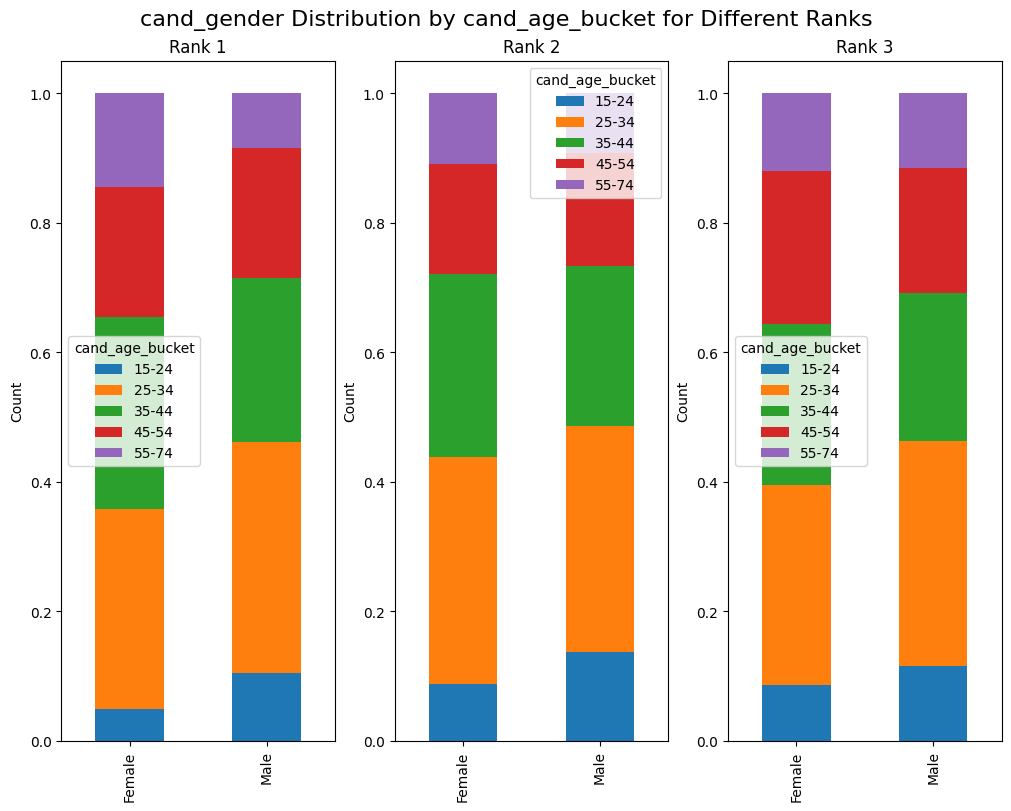

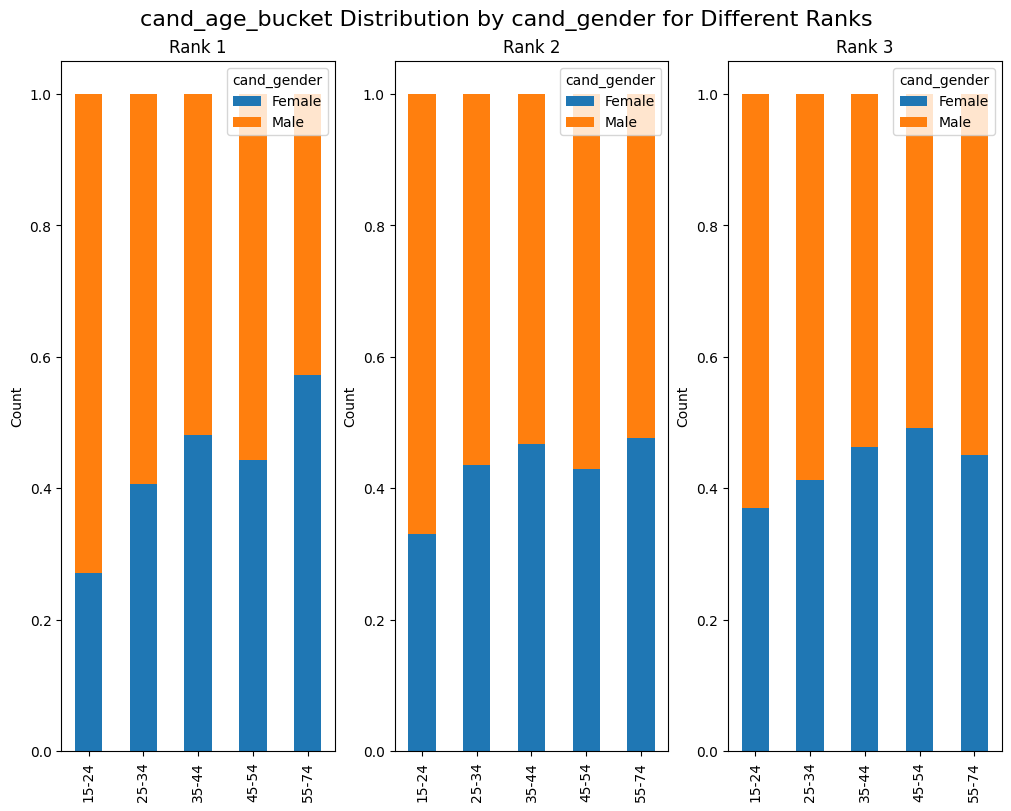

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df.dropna(),'cand_gender','cand_age_bucket',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','cand_gender',r,len(r))

### Education & Age

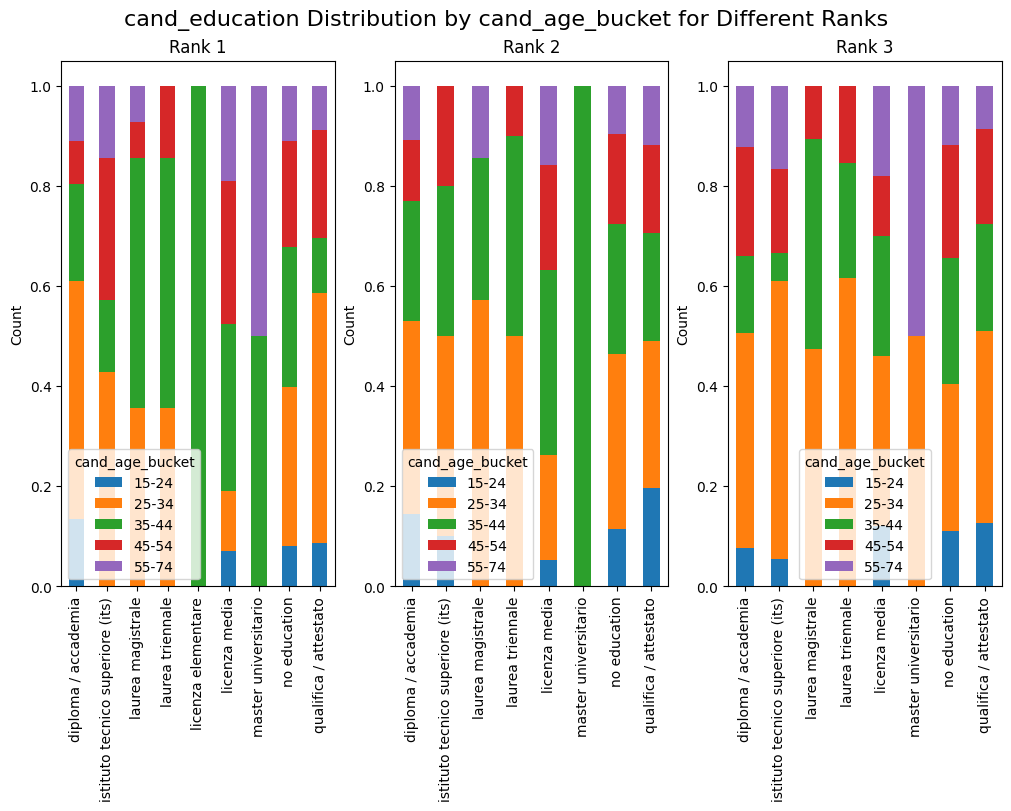

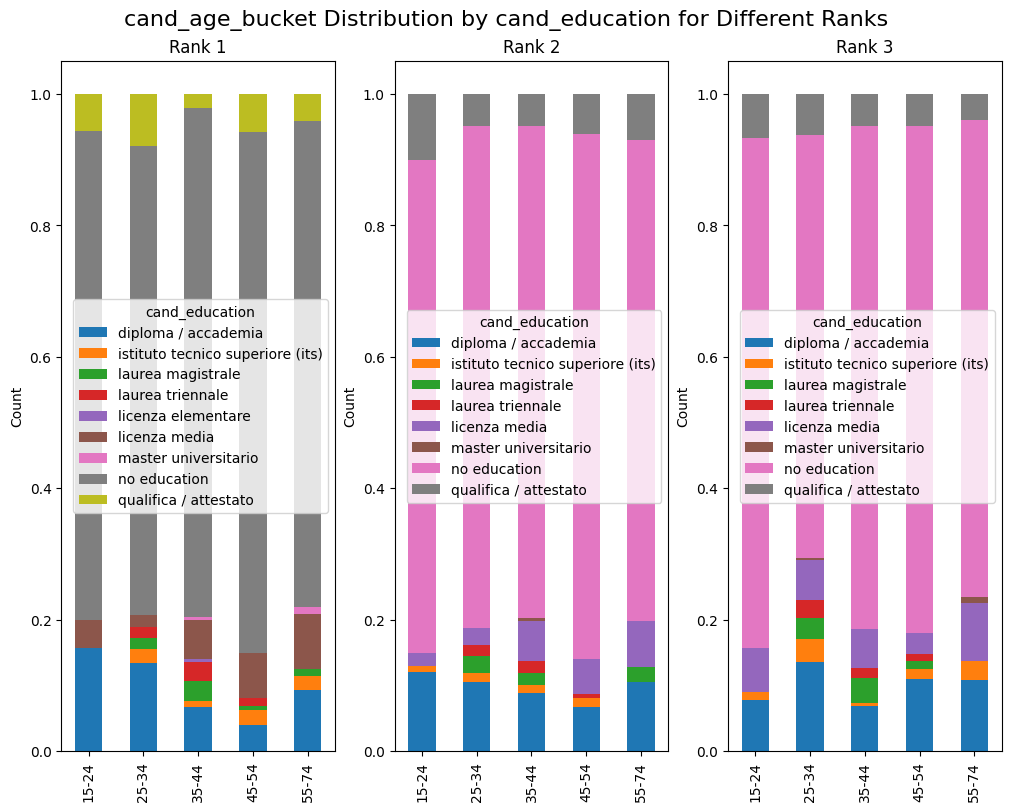

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df.dropna(),'cand_education','cand_age_bucket',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','cand_education',r,len(r))

### Education & Distance

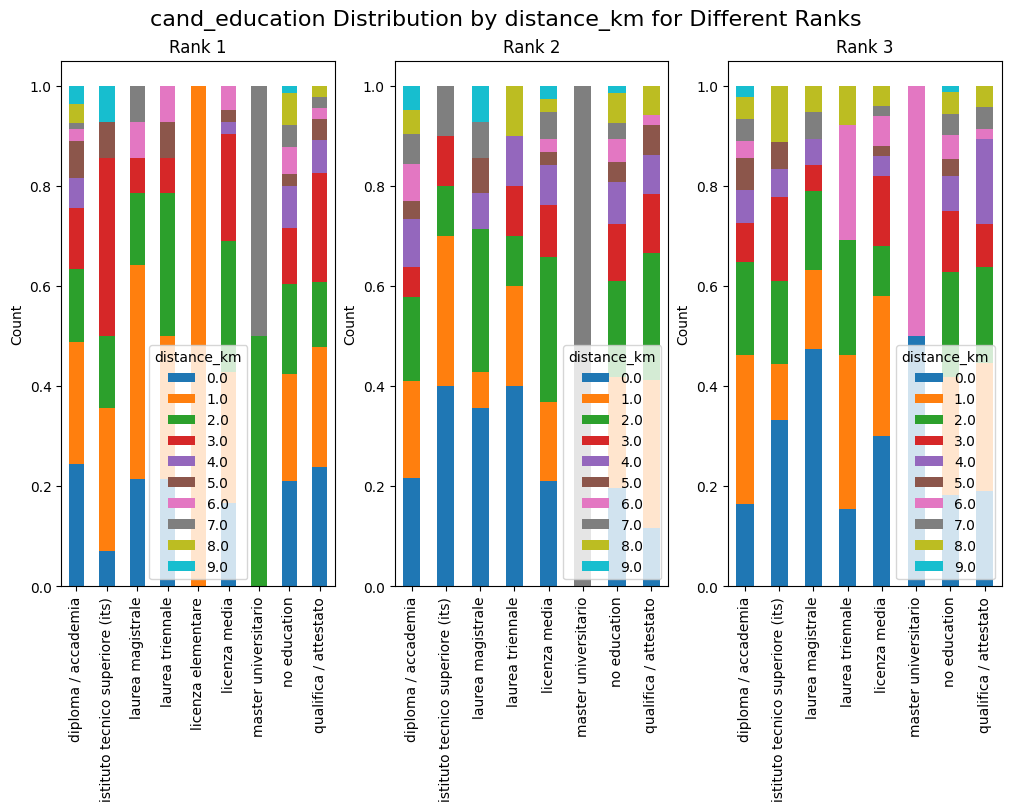

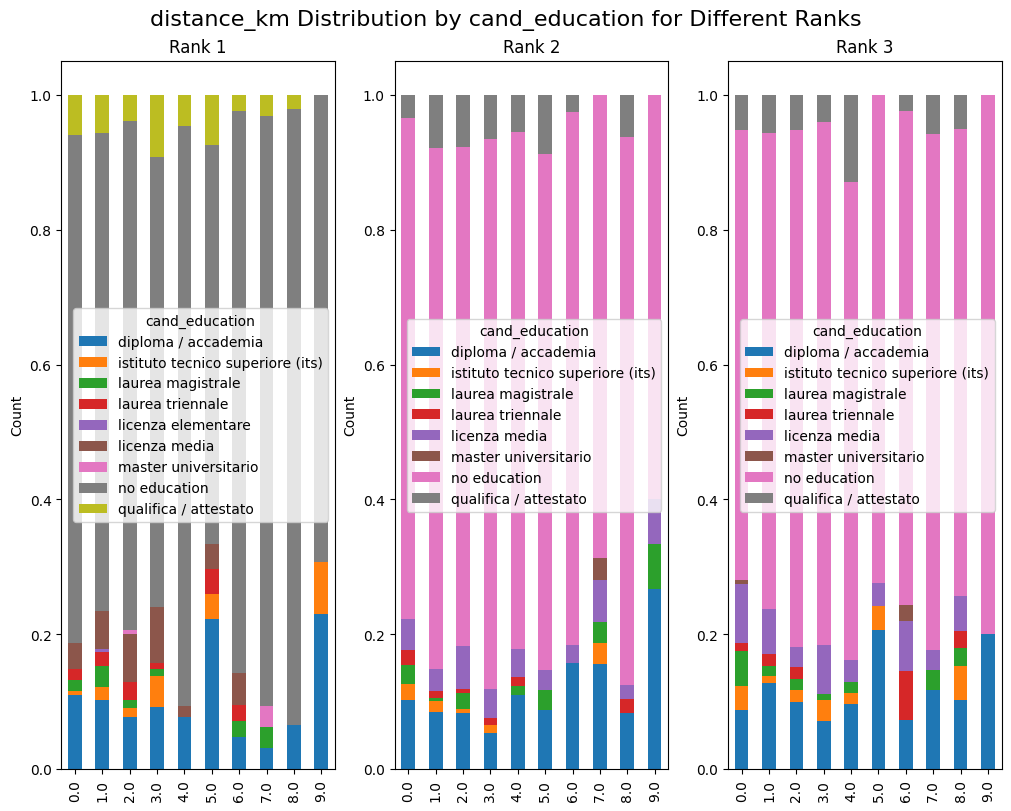

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df.dropna(),'cand_education','distance_km',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'distance_km','cand_education',r,len(r))

 ### Age and Distance

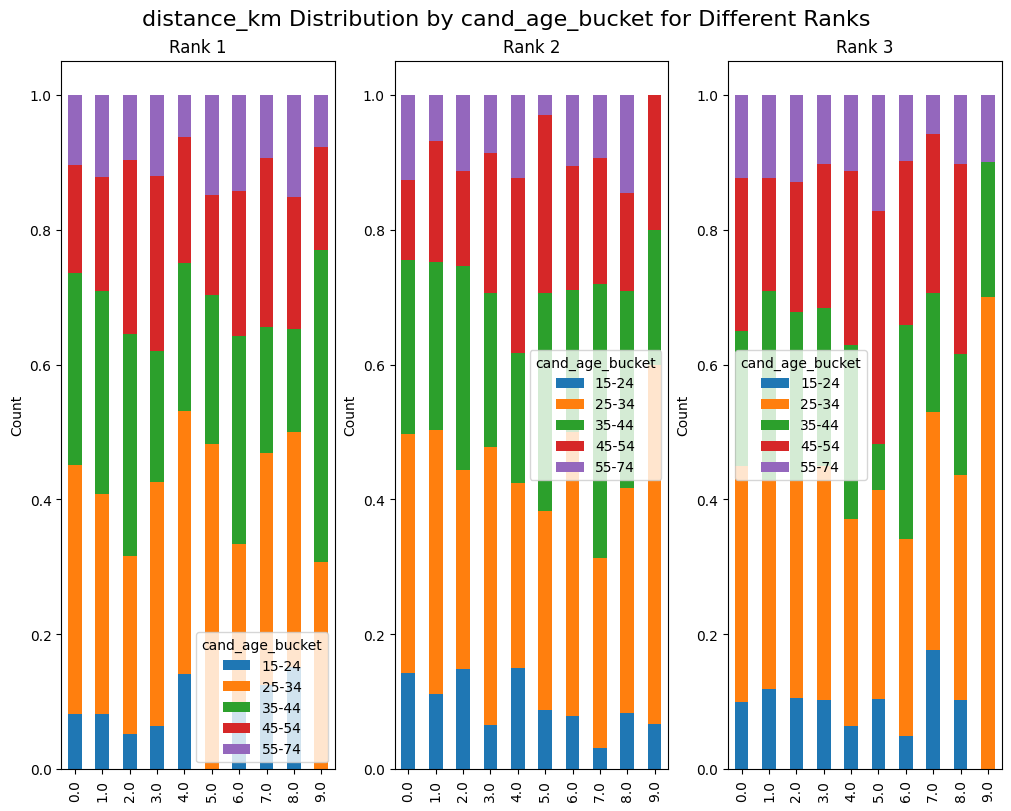

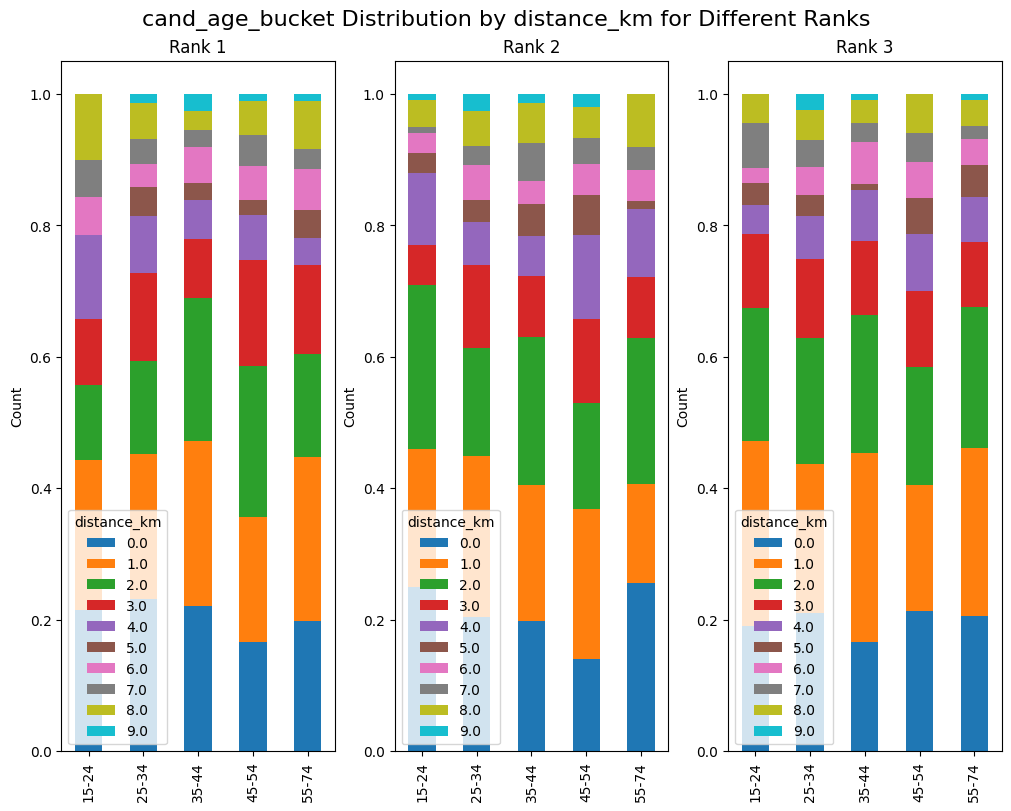

In [ ]:
r = [1,2,3]
f.plot_2_features(direct_matching_df.dropna(),'distance_km','cand_age_bucket',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'cand_age_bucket','distance_km',r,len(r))

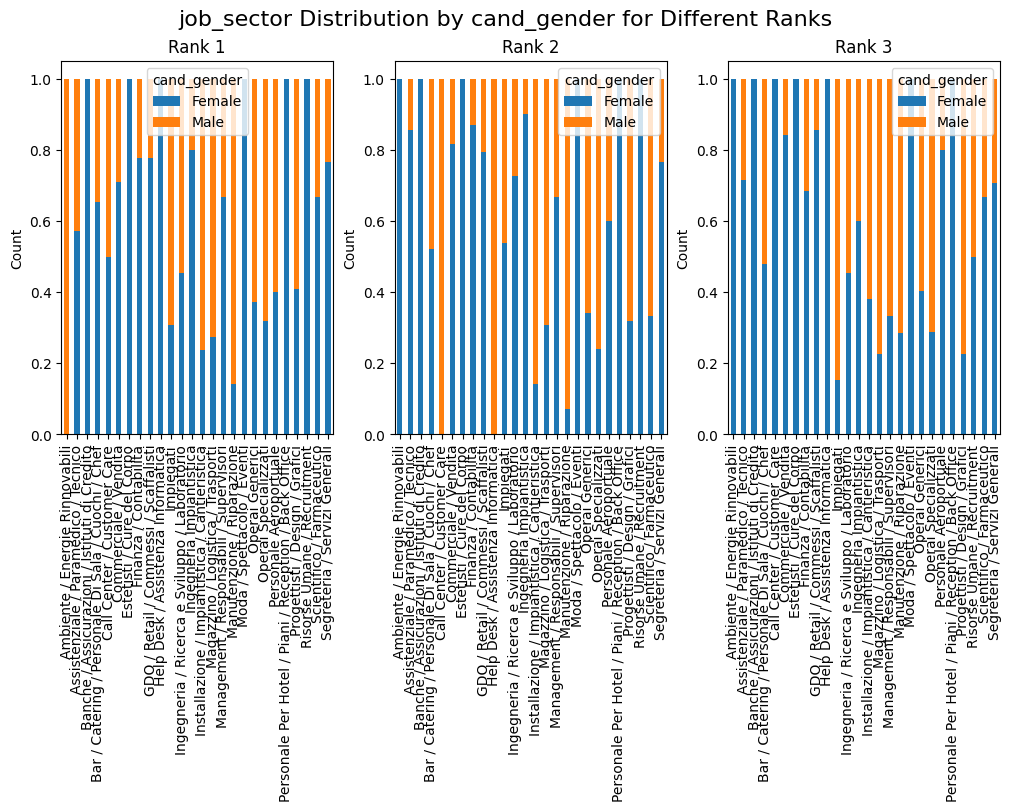

In [ ]:
r = [1,2,3]
#plot_2_features(direct_matching_df.dropna(),'cand_gender','job_sector',r,len(r))
f.plot_2_features(direct_matching_df.dropna(),'job_sector','cand_gender',r,len(r))

## Check correlation between job_professional_category and job_sector

In [ ]:
jobcategories_df = direct_matching_df.dropna().groupby('job_id')['job_professional_category'].value_counts()
for index, value in jobcategories_df.items():
    if value < 10:
      print(index,value)


('OFF_1357_0687', 'Addetto al montaggio (m/f)') 9
('OFF_1745_0198', 'Carrellista/Mulettista') 9
('OFF_2271_0192', 'frigorista') 8
('OFF_2603_0112', 'manutentore') 9
('OFF_4839_0660', 'saldatore/saldatrice') 9
('OFF_789_0870', 'analista finanziario/analista finanziaria') 9
('ORD_16542_0438', 'Operatore di macchine per imballaggio (m/f)') 9
('ORD_18333_0006', 'Meccanico riparatore di macchine (m/f)') 9
('ORD_48061_0590', 'Operaio Generico Elettronico/ Elettrotecnico') 9
('ORD_53862_0059', 'responsabile della contabilità') 9


# Reverse Matching

In [4]:
reverse_matching_df = pd.read_csv('Data/reverse_matching_20240213.csv', sep=';')
reverse_matching_df.head()

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
0,"11,208",OFF_3435_4864,30.609745,99.309860,1,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Ricerca e selezione,segretario/segretaria,Segreteria / Servizi Generali,TV
1,"11,208",ORD_13361_0218,42.466312,96.529259,1,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,Impiegato (m/f),Segreteria / Servizi Generali,PN
2,"11,208",ORD_14183_0606,33.240650,95.374954,2,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,Addetto alle Risorse Umane (m/f),Risorse Umane / Recruitment,TV
3,"11,208",OFF_635_0402,58.744339,94.199844,2,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Ricerca e selezione,Operatore Telemarketing,Call Center / Customer Care,PD
4,"11,208",OFF_5814_0606,27.851854,93.688522,3,Female,25-34,VE,VENETO,"Laurea Magistrale : Economia per arti, cultura...",Tedesco;Ebraico;Rumeno,Lavoro subordinato,assistente amministrativo,Finanza / Contabilità,TV


In [5]:
reverse_matching_df.describe(include="all")

,cand_id,job_id,distance_km,match_score,match_rank,cand_gender,cand_age_bucket,cand_domicile_province,cand_domicile_region,cand_education,cand_languages_spoken,job_contract_type,job_professional_category,job_sector,job_work_province
count,193474,193474,193474.000000,193474.000000,193474.000000,193474,193474,190635,193454,70645,71729,193474,192884,192876,169621
unique,21650,14506,NaN,NaN,NaN,2,5,107,20,1683,237,3,1066,42,107
top,"11,208",ORD_3933_1635,NaN,NaN,NaN,Male,25-34,MI,LOMBARDIA,Licenza media,Rumeno,Lavoro subordinato,commesso di punto vendita/shop assistant,Operai Generici,MI
freq,10,1019,NaN,NaN,NaN,97696,72444,20916,63498,5464,26462,99644,6714,22004,33749
mean,NaN,NaN,38.210087,91.837911,2.923726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,27.047254,12.394169,1.416097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,0.000000,30.001501,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,16.593061,90.506653,2.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,32.815426,96.752945,3.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,57.491835,98.881617,4.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
reverse_matching_df['cand_languages_spoken'] = reverse_matching_df['cand_languages_spoken'].fillna('Italiano')
reverse_matching_df['cand_education'] = reverse_matching_df['cand_education'].fillna('no education')
df_reverse = reverse_matching_df.dropna()

## Plot global distributions

In [11]:
reverse_df_without_duplicates  = df_reverse.drop_duplicates(subset='cand_id')

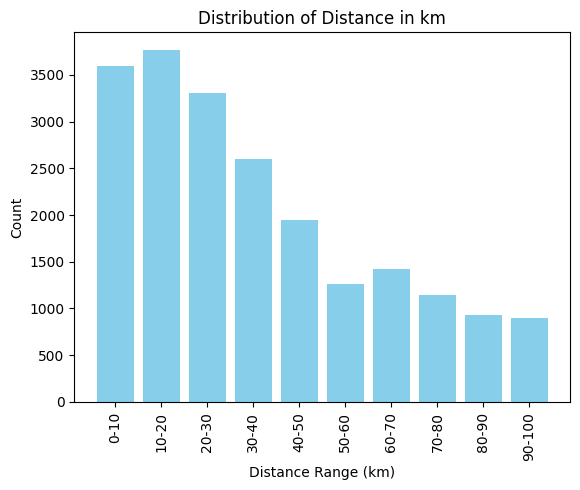

In [13]:
distances_km = reverse_df_without_duplicates.distance_km
distances_km = f.discretize_feature(distances_km)

labels = [f'{i*10}-{(i+1)*10}' for i in range(10)]

# Plot the distribution with labels
plt.bar(labels, distances_km, color='skyblue')
plt.title('Distribution of Distance in km')
plt.xlabel('Distance Range (km)')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

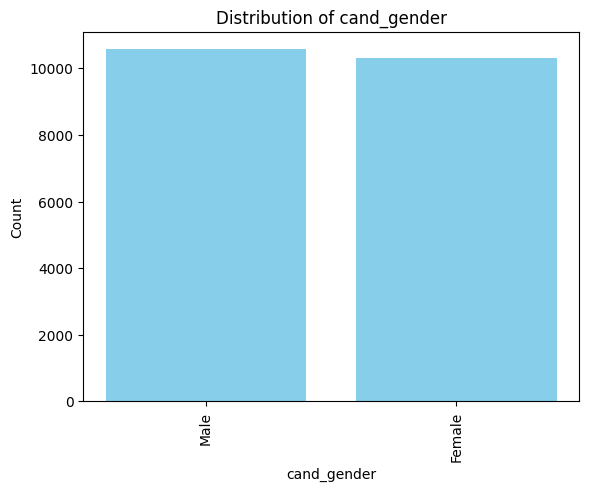

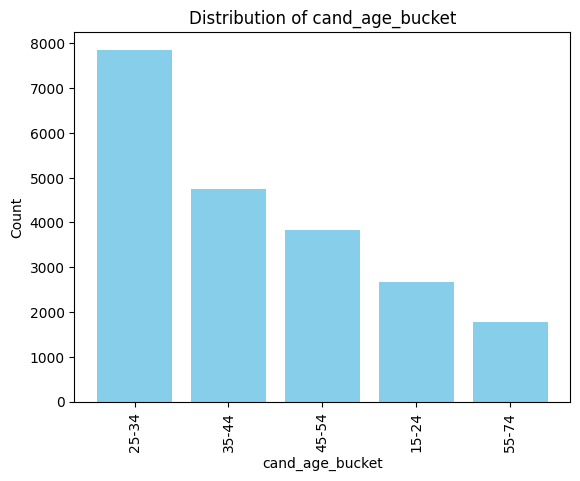

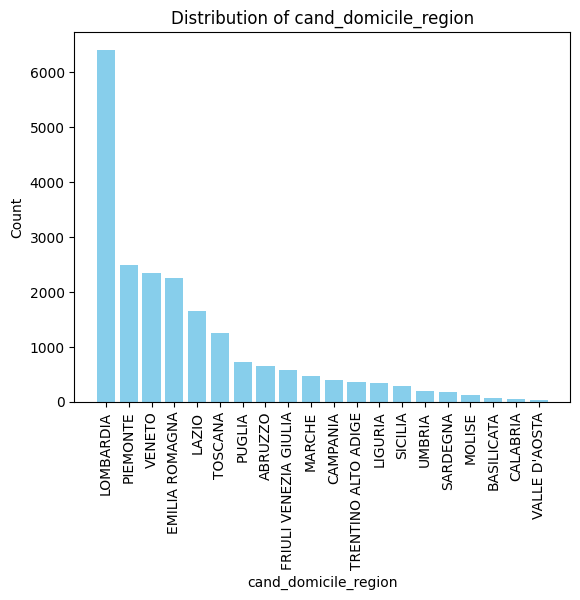

In [14]:
f.show_global_distribution(reverse_df_without_duplicates,'cand_gender')
f.show_global_distribution(reverse_df_without_duplicates,'cand_age_bucket')
f.show_global_distribution(reverse_df_without_duplicates,'cand_domicile_region')

## Plot feautures related to sector

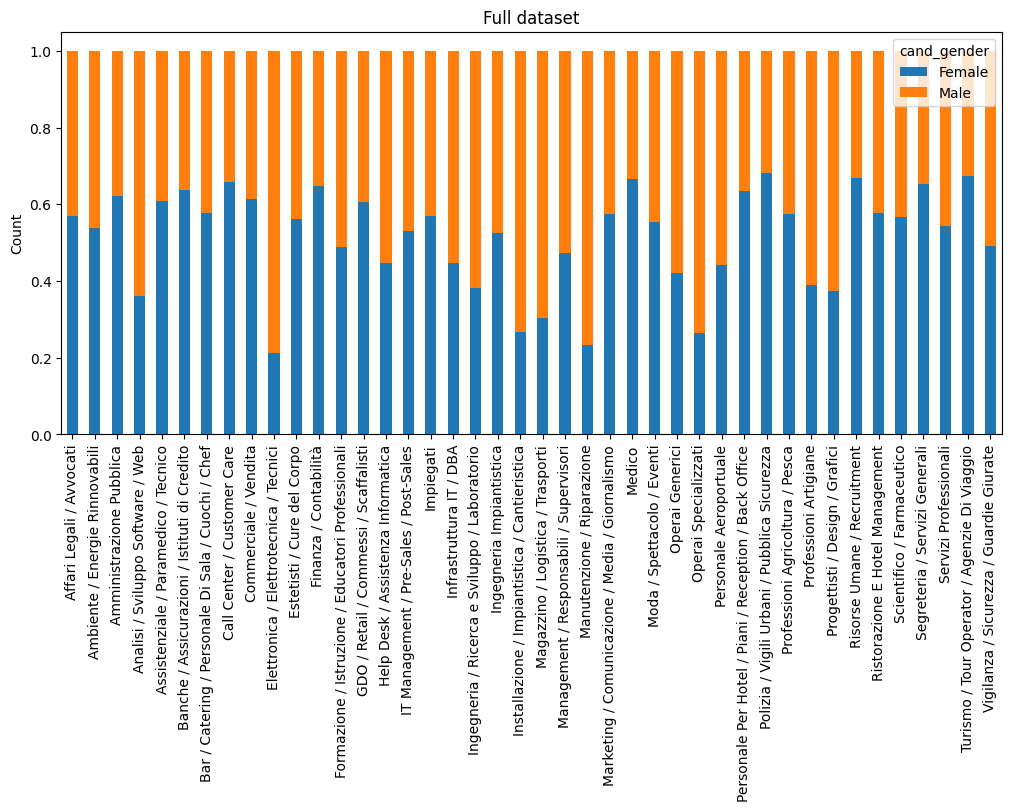

In [32]:
f.plot_2_features(df_reverse, 'job_sector', 'cand_gender', None)

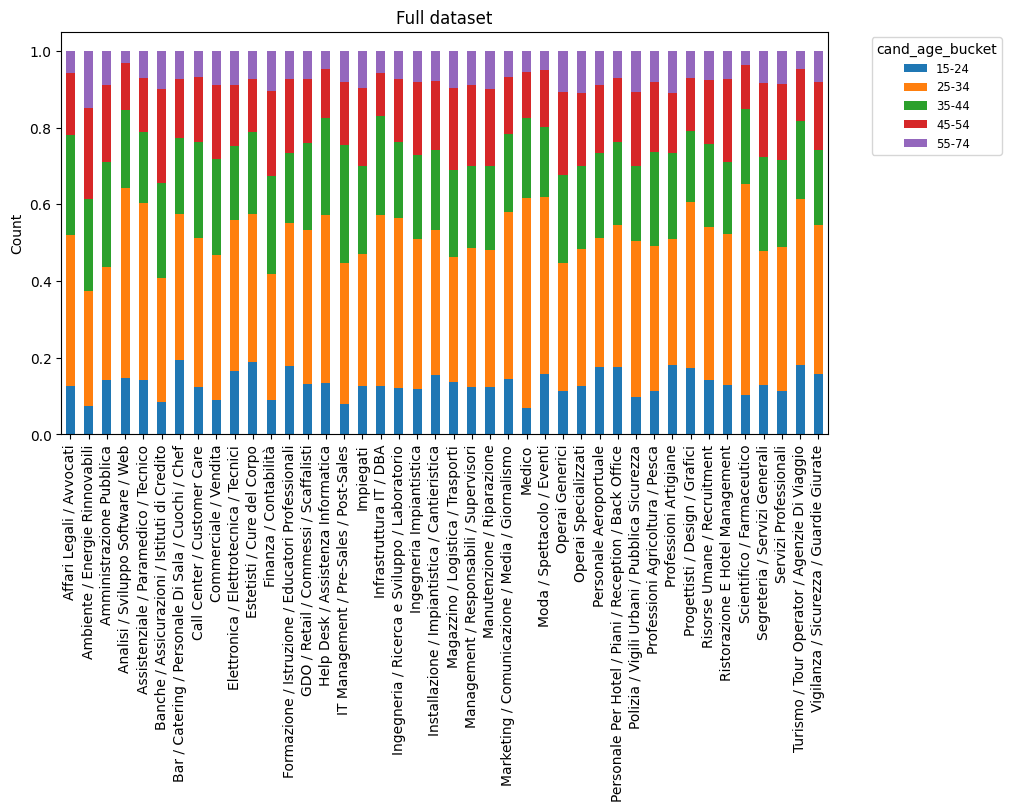

In [19]:
f.plot_2_features(df_reverse, 'job_sector', 'cand_age_bucket', None, legend_outside=True)

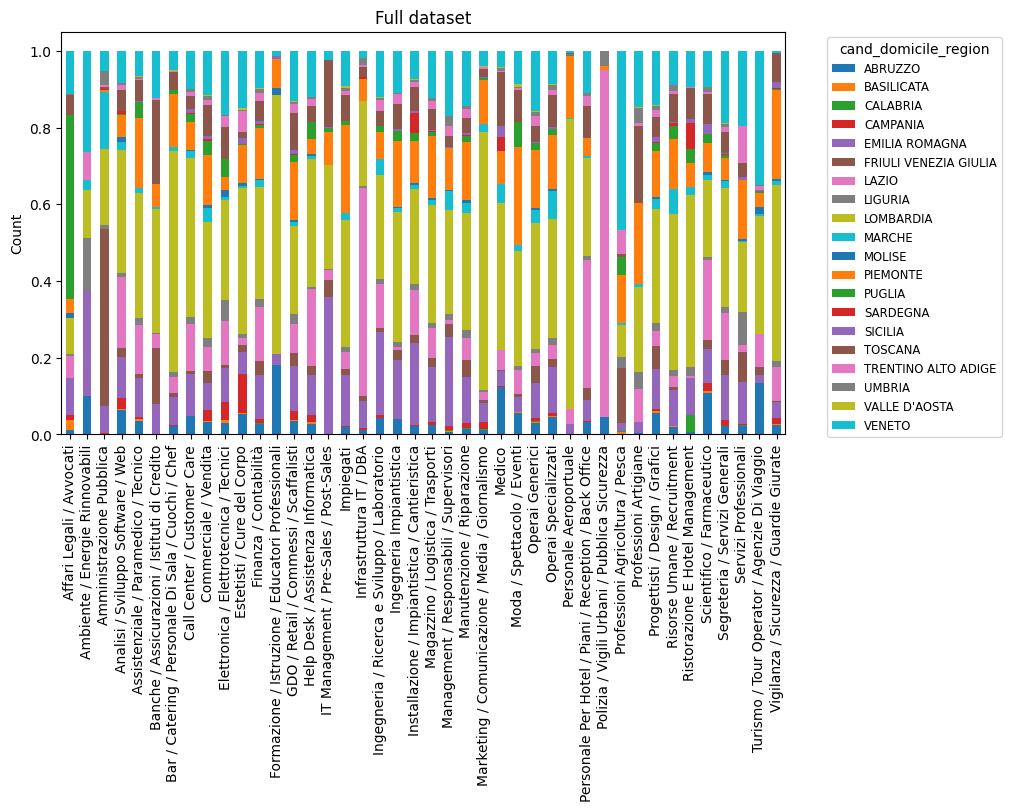

In [20]:
f.plot_2_features(df_reverse, 'job_sector', 'cand_domicile_region', None,legend_outside=True)

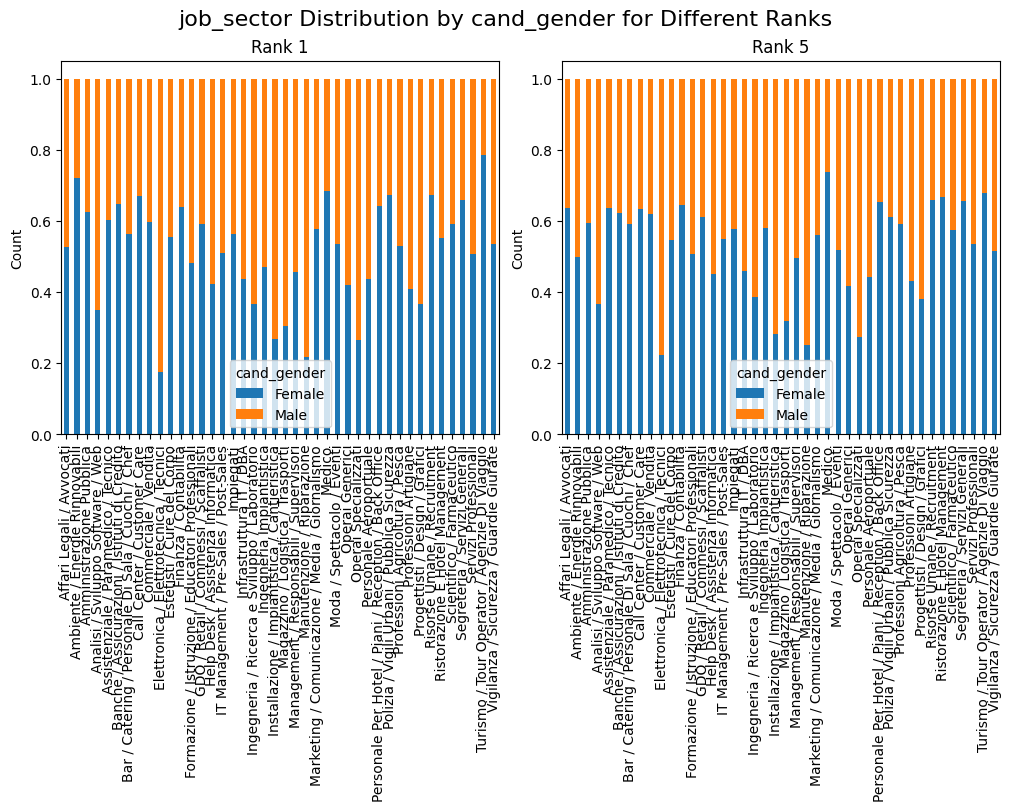

In [21]:
r = [1,5]
f.plot_2_features(df_reverse, 'job_sector', 'cand_gender', r, len(r),None)

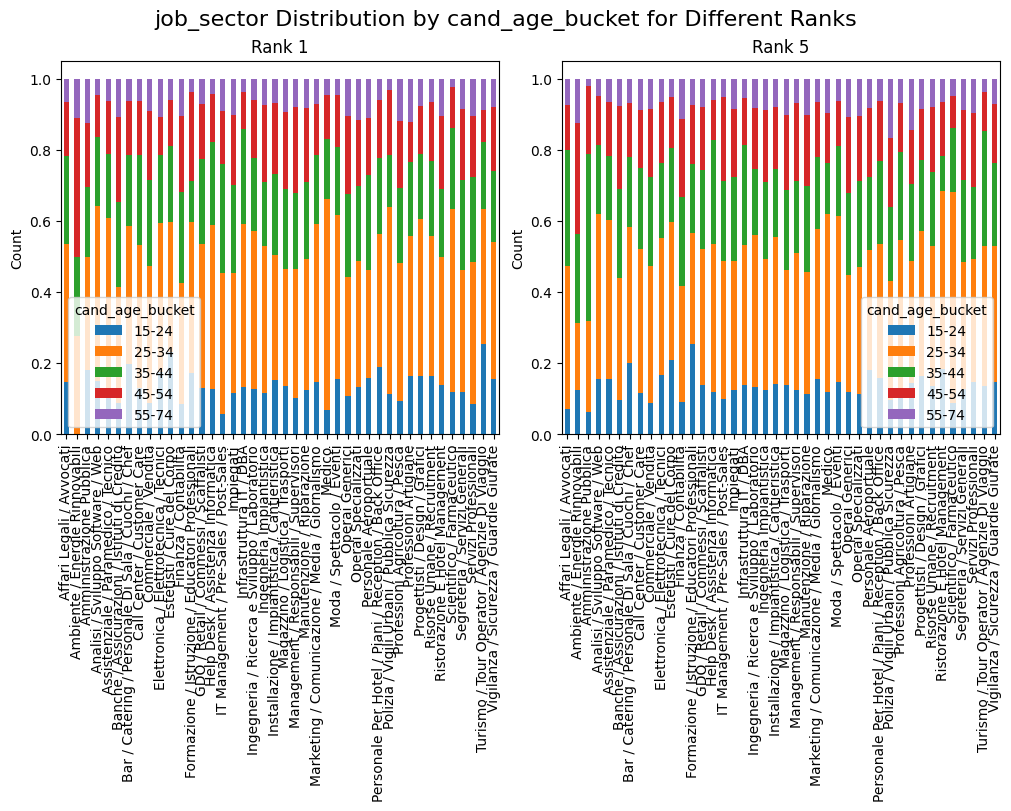

In [22]:
r = [1,5]
f.plot_2_features(df_reverse, 'job_sector', 'cand_age_bucket', r, len(r), None)